In [17]:
#importing libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pyfluids import Fluid, FluidsList, Input

mpl.rcParams["figure.dpi"] = 100

In [18]:
# Default air standard properties
pressure_std = 101325 # Pa
temperature_std = 273.15 + 25 # K #??????? need to make sure this is the right temperature
air_std = Fluid(FluidsList.Air).with_state(Input.pressure(pressure_std), Input.temperature(temperature_std-273.15))

#defining the function
#Cunningham correction factor
#Dp is the particle diameter in meters
#lamda is the mean free path of the gas in meters
#C is the Cunningham correction factor
def c_cunningham(Dp, lamda = 65E-9): 
    kn = 2 * lamda / Dp
    return 1 + kn * (1.257 + 0.4 * np.exp(-1.1 / kn))
    
# mean free path of air calculator
#T is the temperature in Kelvin
#P is the pressure in Pascals
#lamda is the mean free path of the gas in meters
def mean_free_path(temperature, pressure):
    R = 8.314 # J/(mol K) gas constant
    M = 0.0289647 # kg/mol molar mass of air
    air = Fluid(FluidsList.Air).with_state(Input.pressure(pressure), Input.temperature(temperature - 273.15))
    viscosity = air.dynamic_viscosity # Pa s dynamic viscosity
    return 2 * viscosity / (pressure * np.sqrt(8 * M / (np.pi * R * temperature)))

#Reynolds number calculator
#Dp is the particle diameter in meters
#rho_f is the density of the fluid in kg/m^3
#g is the acceleration due to gravity in m/s^2
#C is the Cunningham correction factor
#Re is the Reynolds number
def reynolds_number(Dp, velocity, fluid_density = air_std.density, dynamic_viscosity = air_std.dynamic_viscosity):
    return (Dp * fluid_density * velocity) / dynamic_viscosity

        

In [22]:
# print values for air at 25C and 101325 Pa
print(air_std.dynamic_viscosity, air_std.density, mean_free_path(temperature_std, pressure_std))

1.8448082162002025e-05 1.1843184839089664 6.675479243367345e-08


In [19]:
def settling_velocity(Dp_input, rho_p, temperature, pressure):
    # Check if Dp_input is an array or a single value
    if np.isscalar(Dp_input):
        Dp_array = np.array([Dp_input])  # Convert to array for uniform processing
    else:
        Dp_array = Dp_input  # Use the array as is

    velocities = []  # Empty list to store calculated velocities
    for Dp in Dp_array:  # Process each Dp individually
        g = 9.81  # m/s^2
        l_mfp = mean_free_path(temperature, pressure)
        c_cun = c_cunningham(Dp, l_mfp)
        air = Fluid(FluidsList.Air).with_state(Input.pressure(pressure), Input.temperature(temperature - 273.15))
        mu_f = air.dynamic_viscosity
        rho_f = air.density
        s_velocity = c_cun * (rho_p * g * Dp**2) / (18 * mu_f)  # Stokes settling velocity
        Re = reynolds_number(Dp, s_velocity, fluid_density=rho_f, dynamic_viscosity=mu_f)
        if Re < 1:
            velocities.append(s_velocity)
        else:
            # Adjusted iterative approach for Re > 1, similar to before
            m_p = np.pi * rho_p * Dp**3 / 6
            for i in range(100):
                # c_d = 24 / Re * (1 + 0.15 * Re**(0.687))  # Updated drag coefficient expression
                c_d = 24 / Re * (1 + 3/16 * 0.43 * Re)
                # s_velocity = np.sqrt((4 * m_p * g) / (3 * np.pi * c_d * rho_f * Dp**2))
                s_velocity = np.sqrt((m_p * g) / (1/8 * np.pi * c_d * rho_f * Dp**2))
                Re_new = reynolds_number(Dp, s_velocity, fluid_density=rho_f, dynamic_viscosity=mu_f)
                if abs(Re_new - Re) < 0.01:
                    break  # Exit the loop if the change in Reynolds number is small enough
                else:
                    Re = Re_new
            velocities.append(s_velocity)

    velocities_array = np.array(velocities)  # Convert list to array

    if np.isscalar(Dp_input):
        return velocities_array[0]  # Return a single value if input was scalar
    else:
        return velocities_array  # Return array if input was array

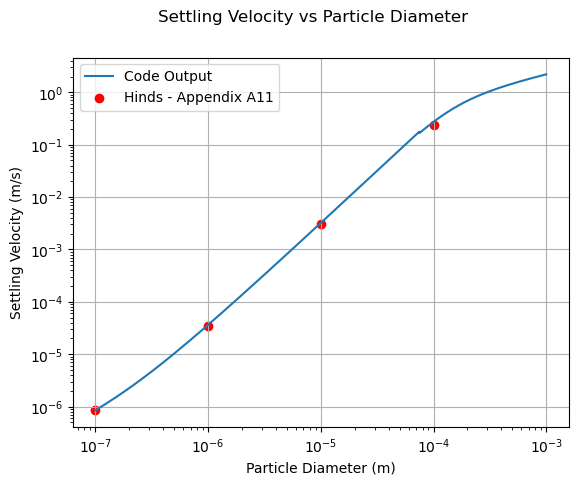

In [20]:
# Homwework 1-2
Dp = np.geomspace(100E-9, 1E-3, 10000)  # Array of particle diameters from 1 nm to 1 micron
velocities = settling_velocity(Dp, 1000, 273, 101325)  # Assuming room temperature is 25°C in Kelvin
plt.plot(Dp, velocities, label='Code Output')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Particle Diameter (m)')
plt.ylabel('Settling Velocity (m/s)')
plt.suptitle('Settling Velocity vs Particle Diameter')
C_actual = np.array([(0.1E-6,1E-6,10E-6, 100E-6), (8.82E-7,3.48E-5, 3.06E-3, 2.40E-1)])
plt.scatter(C_actual[0,:], C_actual[1,:], color='red', label='Hinds - Appendix A11')
plt.legend()
plt.grid()
plt.savefig('2-1.png', bbox_inches='tight')
plt.show()

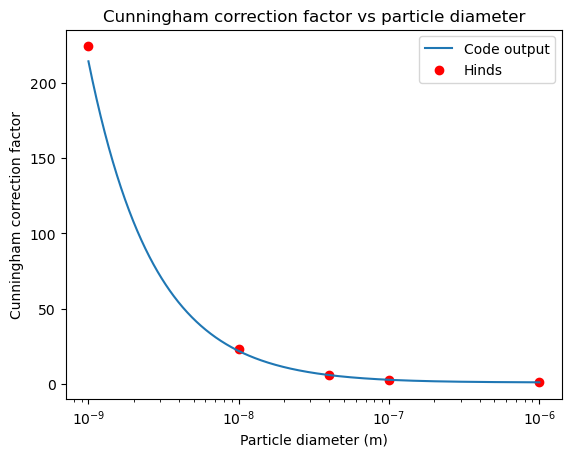

In [21]:
#testing the function Cunningham correction factor
Dp = np.geomspace(1E-9,1E-6,1000) # 1 micron particle
lamda = mean_free_path(290, 101325)
c_cunningham(Dp, lamda)
plt.plot(Dp, c_cunningham(Dp, lamda), label='Code output')
plt.xscale('log')
plt.xlabel('Particle diameter (m)')
plt.ylabel('Cunningham correction factor')
plt.title('Cunningham correction factor vs particle diameter')
# add point to the plot in an array
C_actual = np.array([(1E-6,1E-7,4E-8, 1E-9, 1E-8), (1.2,3, 6, 224, 22.97)])
plt.scatter(C_actual[0,:], C_actual[1,:], color='red', label='Hinds')
plt.legend()
plt.savefig('2-2.png', bbox_inches='tight')
plt.show()